In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
from random import choice

from numpy.random import default_rng

In [3]:
N_ROWS = 100_000

In [4]:
rng = default_rng()

In [5]:
# Make random labels
y = rng.integers(2, size=N_ROWS)

In [6]:
# Make some random numeric features
x1 = rng.normal(loc=y)
x2 = rng.normal(loc=y + x1)
x3 = rng.normal(x1)
x4 = rng.normal(x2)

In [7]:
# Make some random categoricals
pos_colors = [
    "red",
    "red",
    "orange",
    "orange",
    "yellow",
    "yellow",
    "green",
    "blue",
    "white",
    "black",
]

neg_colors = [
    "red",
    "orange",
    "yellow",
    "green",
    "green",
    "blue",
    "blue",
    "purple",
    "purple",
    "white",
    "black",
]

# Probably can do this without a loop...
cat1 = []
for label in y:
    if label == 1:
        cat1.append(choice(pos_colors))
    else:
        cat1.append(choice(neg_colors))


# And an ordered list
size = ["x-small", "small", "medium", "large", "x-large"]

size_i = np.add(rng.integers(4, size=len(y)), y)

cat2 = np.take(size, size_i)

In [8]:
# Put it into a nice dataframe
df = pd.DataFrame(
    data={
        "y": y,
        "x1": x1,
        "x2": x2,
        "x3": x3,
        "x4": x4,
        "cat1": cat1,
        "cat2": cat2,
    }
)

In [9]:
# Randomly drop some values
for col in df.columns:
    # But not the labels
    if col == "y":
        continue

    # And also not our ordinal so we don't have to worry about filling it
    if col == "cat2":
        continue

    mask = rng.choice([0, 1], p=[0.9, 0.1], size=len(df[col])).astype(bool)
    df.loc[mask, col] = np.nan

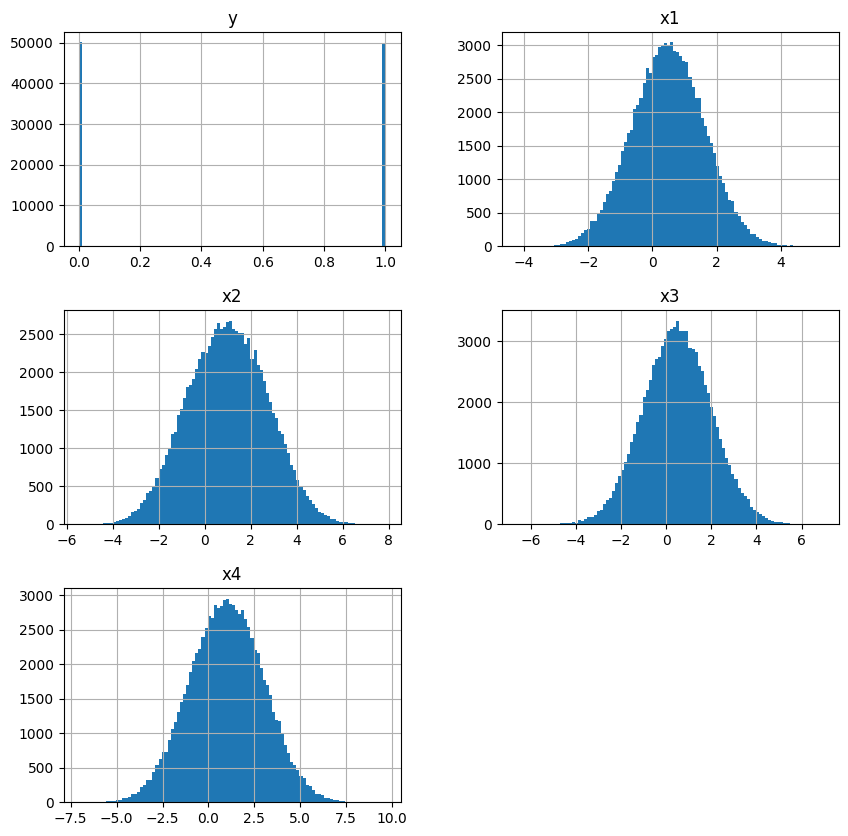

In [10]:
_ = df.hist(bins=100, figsize=(10, 10))

## Pandas Pipelines

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [12]:
# We need to define a pipeline for each group of columns we which to apply a set of transforms to

numeric_pipeline = Pipeline(
    steps=[
        ("impute_missing", SimpleImputer(strategy="median")),
        ("standard_scale", StandardScaler()),
    ]
)

unordered_categories_pipeline = Pipeline(
    steps=[
        ("one-hot_encode ", OneHotEncoder()),
    ]
)

ordered_categories_pipeline = Pipeline(
    steps=[
        ("size_encoder", OrdinalEncoder(categories=[size])),
    ]
)

In [29]:
# Then we use ColumnTransformer to assign each pipeline to a set of columns
logistic_step_name = "logistic_regression"

final_pipeline = Pipeline(
    steps=[
        (
            "feature_processing",
            ColumnTransformer(
                transformers=[
                    ("numeric_pipeline", numeric_pipeline, ["x1", "x2", "x3", "x4"]),
                    (
                        "unordered_categories_pipeline",
                        unordered_categories_pipeline,
                        ["cat1"],
                    ),
                    (
                        "ordered_categories_pipeline",
                        ordered_categories_pipeline,
                        ["cat2"],
                    ),
                ],
                remainder="drop",
            ),
        ),
        (
            logistic_step_name,
            LogisticRegression(
                penalty="l2",
                class_weight="balanced",
                solver="saga",
                random_state=1337,
                max_iter=1_000,
            ),
        ),
    ],
)

In [31]:
# And let's search different regularization strengths
param_grid = {
    f"{logistic_step_name}__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(final_pipeline, param_grid, n_jobs=-1, error_score="raise")

search.fit(X=x_train, y=y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.818):
{'logistic_regression__C': 21.54434690031882}


In [32]:
search.score(x_train, y_train), search.score(x_test, y_test)

(0.8188, 0.8194)

In [33]:
from sklearn.metrics import (
    PrecisionRecallDisplay,
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
)

In [14]:
y = df["y"]
x = df.drop("y", axis="columns")

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1337, stratify=y
)

final_pipeline.fit(x_train)

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scale',
                                                                   StandardScaler())]),
                                                  ['x1', 'x2', 'x3', 'x4']),
                                                 ('unordered_categories_pipeline',
                                                  Pipeline(steps=[('one-hot_encode ',
                                                                   OneHotEncoder())]),
                                                  ['cat1']),
                                                 ('ordered_categories_pipeline',
                                                  Pipeline(steps=[('size_encoder',
                                                                   OrdinalEncoder(categories=[['x-small',
                                                                                               'small',
                                                                                               'medium',
                                                                                               'large',
                                                                                               'x-large']]))]),
                                                  ['cat2'])]))])

In [15]:
trans_train_x_df = pd.DataFrame(
    final_pipeline.transform(x_train), columns=final_pipeline.get_feature_names_out()
)

trans_test_x_df = pd.DataFrame(
    final_pipeline.transform(x_test), columns=final_pipeline.get_feature_names_out()
)

In [16]:
trans_test_x_df

,numeric_pipeline__x1,numeric_pipeline__x2,numeric_pipeline__x3,numeric_pipeline__x4,unordered_categories_pipeline__cat1_black,unordered_categories_pipeline__cat1_blue,unordered_categories_pipeline__cat1_green,unordered_categories_pipeline__cat1_orange,unordered_categories_pipeline__cat1_purple,unordered_categories_pipeline__cat1_red,unordered_categories_pipeline__cat1_white,unordered_categories_pipeline__cat1_yellow,unordered_categories_pipeline__cat1_nan,ordered_categories_pipeline__cat2
0,0.925550,0.197154,-0.409625,0.665136,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.000637,-1.308668,-0.003492,-0.988622,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.729406,-0.700848,-0.820241,-0.690264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,-0.286451,-0.812884,-0.591596,-0.722519,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,-0.560902,-0.032236,-0.217833,0.120268,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.049501,-0.041254,1.180679,0.226647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
19996,1.114325,1.648809,-0.003492,1.445617,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
19997,1.058865,1.490511,1.535027,1.874367,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19998,0.185265,0.450301,-0.748352,-0.055537,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


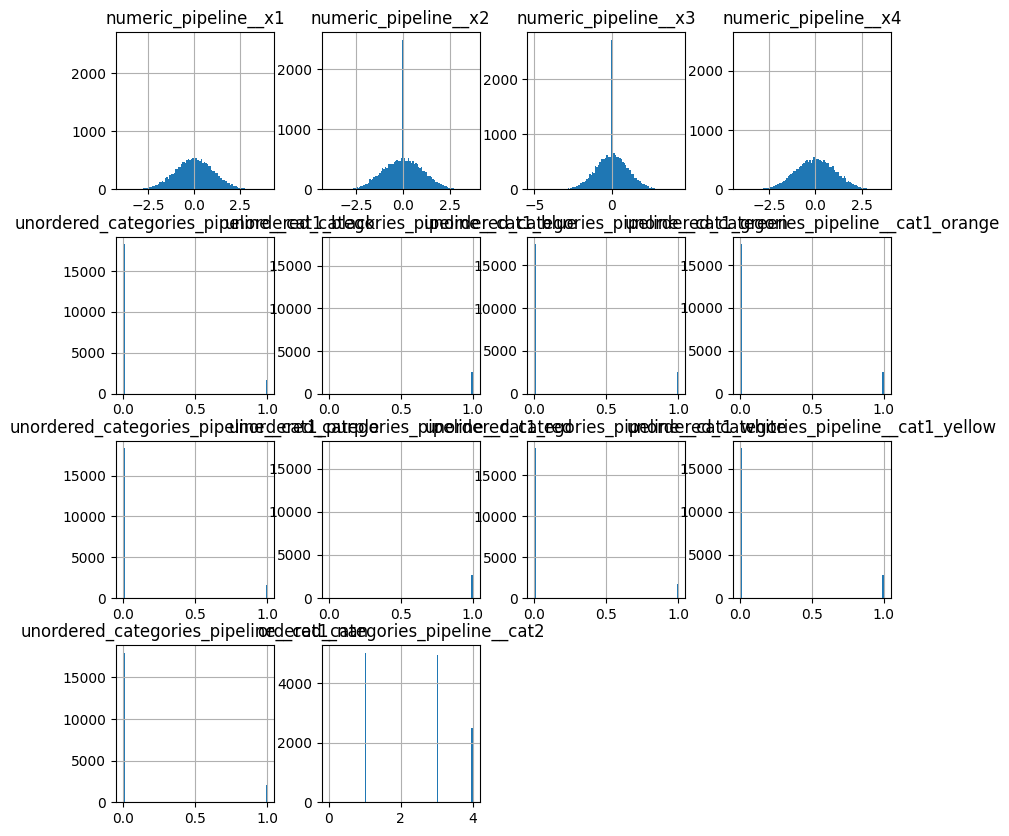

In [22]:
_ = trans_test_x_df.hist(bins=100, figsize=(10, 10))